# Fault Prediction: Engine Condition (RFC, GSCV, CVS)

## 1. Data Cleaning and Handling Missing Values
- Remove Columns with High Missingness 
- Imputation of Missing Values: Mean/Median Imputation, k-Nearest Neighbors (KNN) Imputation

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


# Load the dataset
data = pd.read_csv('live25.csv')

# Step 1: Remove columns with a high proportion of missing values (>80% missing)
threshold = 0.8
data = data.loc[:, data.isnull().mean() < threshold]

# Step 2: Fill remaining missing values
# Separate columns for mean/median imputation vs. KNN imputation
# Mean/Median Imputation for simpler features
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    if data[column].isnull().mean() > 0:
        data[column].fillna(data[column].median(), inplace=True)

# KNN Imputation for remaining numerical features with complex patterns
# Select only columns with missing values for KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
data_knn = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)

# Display the cleaned data
data_knn.info()
data_knn


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ENGINE_RUN_TINE ()                     3804 non-null   float64
 1   ENGINE_RPM ()                          3804 non-null   float64
 2   VEHICLE_SPEED ()                       3804 non-null   float64
 3   THROTTLE ()                            3804 non-null   float64
 4   ENGINE_LOAD ()                         3804 non-null   float64
 5   COOLANT_TEMPERATURE ()                 3804 non-null   float64
 6   LONG_TERM_FUEL_TRIM_BANK_1 ()          3804 non-null   float64
 7   SHORT_TERM_FUEL_TRIM_BANK_1 ()         3804 non-null   float64
 8   INTAKE_MANIFOLD_PRESSURE ()            3804 non-null   float64
 9   FUEL_TANK ()                           3804 non-null   float64
 10  ABSOLUTE_THROTTLE_B ()                 3804 non-null   float64
 11  PEDA

,ENGINE_RUN_TINE (),ENGINE_RPM (),VEHICLE_SPEED (),THROTTLE (),ENGINE_LOAD (),COOLANT_TEMPERATURE (),LONG_TERM_FUEL_TRIM_BANK_1 (),SHORT_TERM_FUEL_TRIM_BANK_1 (),INTAKE_MANIFOLD_PRESSURE (),FUEL_TANK (),...,RELATIVE_THROTTLE_POSITION (),INTAKE_AIR_TEMP (),TIMING_ADVANCE (),CATALYST_TEMPERATURE_BANK1_SENSOR1 (),CATALYST_TEMPERATURE_BANK1_SENSOR2 (),CONTROL_MODULE_VOLTAGE (),COMMANDED_EVAPORATIVE_PURGE (),TIME_RUN_WITH_MIL_ON (),TIME_SINCE_TROUBLE_CODES_CLEARED (),DISTANCE_TRAVELED_WITH_MIL_ON ()
0,0.0,0.0,17.647058,0.000000,26.0,-4.68750,0.00000,101.0,36.078430,49.803921,...,26.0,5.0,438.000000,300.799988,12.421,0.000000,0.0,8808.0,0.0,255.0
1,0.0,0.0,17.647058,0.000000,26.0,-4.68750,0.00000,101.0,36.078430,49.803921,...,26.0,5.0,438.000000,300.799988,12.421,0.000000,0.0,8808.0,0.0,255.0
2,0.0,0.0,19.607843,0.000000,26.0,-4.68750,0.00000,99.0,36.078430,49.803921,...,26.0,5.0,438.000000,300.799988,12.421,0.000000,0.0,8808.0,0.0,255.0
3,0.0,0.0,19.607843,0.000000,26.0,-4.68750,0.00000,99.0,36.078430,49.803921,...,26.0,5.0,438.000000,300.799988,12.421,0.000000,0.0,8808.0,0.0,255.0
4,0.0,0.0,19.607843,0.000000,26.0,-4.68750,0.00000,99.0,36.078430,52.156864,...,26.0,5.0,438.000000,300.799988,11.679,0.000000,0.0,8808.0,0.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,690.5,0.0,15.686275,25.490196,89.0,-0.78125,-0.78125,28.0,32.156864,47.450981,...,48.0,2.0,442.399994,345.799988,13.652,25.490196,0.0,8839.0,0.0,255.0
3800,690.5,0.0,15.686275,25.490196,89.0,-0.78125,-0.78125,28.0,32.156864,47.450981,...,48.0,2.0,442.399994,345.799988,13.652,25.490196,0.0,8839.0,0.0,255.0
3801,690.5,0.0,15.686275,25.490196,89.0,-0.78125,-0.78125,28.0,32.156864,47.450981,...,48.0,2.0,441.399994,344.700012,13.652,25.490196,0.0,8839.0,0.0,255.0
3802,690.5,0.0,15.686275,25.490196,89.0,-0.78125,-0.78125,28.0,32.156864,47.450981,...,48.0,2.0,441.399994,344.700012,13.652,25.490196,0.0,8839.0,0.0,255.0


## 2. Creating Synthetic eng_condition column:
- Since there is no explicit eng_condition column, we will create a synthetic eng_condition column to simulate real-time values.
- Columns used to calc this synthetic eng_cond column are: 'ENGINE_RPM ()', 'VEHICLE_SPEED ()', 'ENGINE_LOAD ()', 'COOLANT_TEMPERATURE ()', 'CATALYST_TEMPERATURE_BANK1_SENSOR1 ()', 'CONTROL_MODULE_VOLTAGE ()'.
- The eng_condition value is set to 0 or 1 based on these 6 column values

In [6]:
# Step 2: Synthetic Label Creation
# Define the label `eng_condition` based on statistical thresholds (90th percentile for high values, 10th percentile for low values)

# Set thresholds for each feature based on quantiles
rpm_threshold = data_knn['ENGINE_RPM ()'].quantile(0.90) if 'ENGINE_RPM ()' in data_knn.columns else None
speed_threshold = data_knn['VEHICLE_SPEED ()'].quantile(0.90) if 'VEHICLE_SPEED ()' in data_knn.columns else None
load_threshold = data_knn['ENGINE_LOAD ()'].quantile(0.90) if 'ENGINE_LOAD ()' in data_knn.columns else None
coolant_temp_threshold = data_knn['COOLANT_TEMPERATURE ()'].quantile(0.90) if 'COOLANT_TEMPERATURE ()' in data_knn.columns else None
catalyst_temp_threshold = data_knn['CATALYST_TEMPERATURE_BANK1_SENSOR1 ()'].quantile(0.90) if 'CATALYST_TEMPERATURE_BANK1_SENSOR1 ()' in data_knn.columns else None
voltage_threshold = data_knn['CONTROL_MODULE_VOLTAGE ()'].quantile(0.10) if 'CONTROL_MODULE_VOLTAGE ()' in data_knn.columns else None

# Create synthetic target 'eng_condition' based on these thresholds
data_knn['eng_condition'] = np.where(
    ((data_knn['ENGINE_RPM ()'] > rpm_threshold) if rpm_threshold else False) |
    ((data_knn['VEHICLE_SPEED ()'] > speed_threshold) if speed_threshold else False) |
    ((data_knn['ENGINE_LOAD ()'] > load_threshold) if load_threshold else False) |
    ((data_knn['COOLANT_TEMPERATURE ()'] > coolant_temp_threshold) if coolant_temp_threshold else False) |
    ((data_knn['CATALYST_TEMPERATURE_BANK1_SENSOR1 ()'] > catalyst_temp_threshold) if catalyst_temp_threshold else False) |
    ((data_knn['CONTROL_MODULE_VOLTAGE ()'] < voltage_threshold) if voltage_threshold else False),
    1, 0
)

# Display the data with the new synthetic target column
data_knn[['eng_condition']].value_counts(), data_knn


(eng_condition
 0                2808
 1                 996
 Name: count, dtype: int64,
       ENGINE_RUN_TINE ()  ENGINE_RPM ()  VEHICLE_SPEED ()  THROTTLE ()  \
 0                    0.0            0.0         17.647058     0.000000   
 1                    0.0            0.0         17.647058     0.000000   
 2                    0.0            0.0         19.607843     0.000000   
 3                    0.0            0.0         19.607843     0.000000   
 4                    0.0            0.0         19.607843     0.000000   
 ...                  ...            ...               ...          ...   
 3799               690.5            0.0         15.686275    25.490196   
 3800               690.5            0.0         15.686275    25.490196   
 3801               690.5            0.0         15.686275    25.490196   
 3802               690.5            0.0         15.686275    25.490196   
 3803               690.5            0.0         16.078432    25.882353   
 
       EN

## 3. Feature Selection:

### Correlated Features: 
    Features that are highly correlated with each other add redundancy. The model doesn’t benefit from having multiple columns with nearly identical information, and it can overfit if these correlations are not controlled. The process to handle this includes:
### Correlation Matrix: 
    Calculate the correlation between features, and remove one of each highly correlated pair (e.g., if two features have >90% correlation).
### Variance Inflation Factor (VIF): 
    This is an alternative approach that calculates how much a feature’s variance is inflated due to multicollinearity. Features with a high VIF are usually removed.

Selected Features after Correlation and VIF Filtering:
Index(['COOLANT_TEMPERATURE ()', 'LONG_TERM_FUEL_TRIM_BANK_1 ()',
       'INTAKE_AIR_TEMP ()', 'CONTROL_MODULE_VOLTAGE ()'],
      dtype='object')


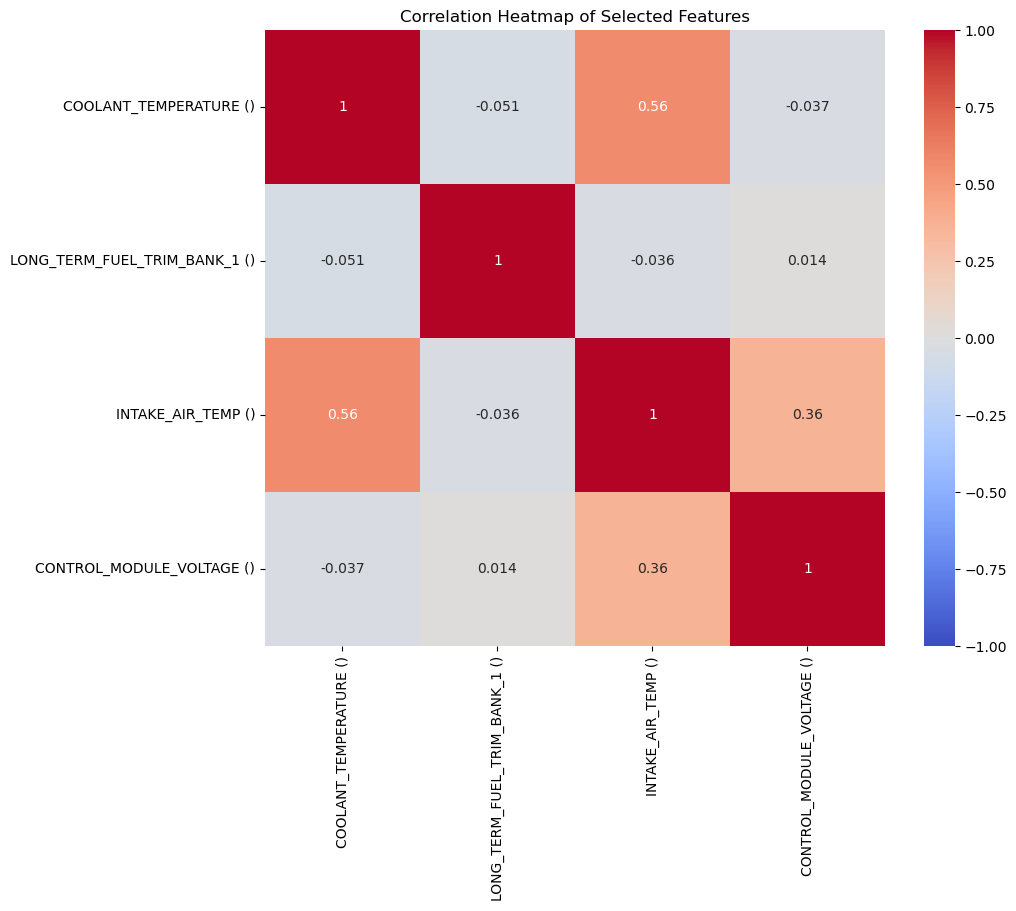

,COOLANT_TEMPERATURE (),LONG_TERM_FUEL_TRIM_BANK_1 (),INTAKE_AIR_TEMP (),CONTROL_MODULE_VOLTAGE (),eng_condition
0,-4.68750,0.00000,5.0,0.000000,0
1,-4.68750,0.00000,5.0,0.000000,0
2,-4.68750,0.00000,5.0,0.000000,0
3,-4.68750,0.00000,5.0,0.000000,0
4,-4.68750,0.00000,5.0,0.000000,0
...,...,...,...,...,...
3799,-0.78125,-0.78125,2.0,25.490196,1
3800,-0.78125,-0.78125,2.0,25.490196,1
3801,-0.78125,-0.78125,2.0,25.490196,1
3802,-0.78125,-0.78125,2.0,25.490196,1


In [8]:

# Step 3: Feature Selection and Multicollinearity Handling

# Drop target column
features_data = data_knn.drop(columns=['eng_condition'])

# 1. Drop columns with near-zero variance
low_variance_threshold = 0.01
low_variance_cols = features_data.columns[features_data.var() < low_variance_threshold]
features_data = features_data.drop(columns=low_variance_cols)

# Calculate Correlation Matrix
corr_matrix = features_data.corr().abs()

# 2. Set a correlation threshold (e.g., 0.90) and remove highly correlated features
threshold = 0.90
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
features_data = features_data.drop(columns=high_corr_features)

# 3. Calculate VIF for remaining features
vif_data = pd.DataFrame()
vif_data['Feature'] = features_data.columns
vif_data['VIF'] = [variance_inflation_factor(features_data.values, i) for i in range(features_data.shape[1])]

# Drop features with high VIF (e.g., VIF > 10)
vif_threshold = 10
low_vif_features = vif_data[vif_data['VIF'] < vif_threshold]['Feature'].tolist()
selected_features_data = features_data[low_vif_features]

# Display selected features and plot correlation heatmap
print("Selected Features after Correlation and VIF Filtering:")
print(selected_features_data.columns)

# Plot heatmap of the selected features to confirm reduced multicollinearity
plt.figure(figsize=(10, 8))
sns.heatmap(selected_features_data.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

# Update the main dataset with the selected features and target
final_data = selected_features_data.copy()
final_data['eng_condition'] = data_knn['eng_condition']

final_data    # Reduced from 26 cols => 4+1(eng_cond) cols


## 4. Feature Scaling:
### Standardization: 
    For algorithms like Random Forest, scaling isn't always essential, but it can improve interpretability and model stability. Standardization rescales features to have a mean of 0 and a standard deviation of 1, which can be important if using methods like KNN in imputation.

In [10]:

# Step 4: Feature Scaling

# Separate features and target
X = final_data.drop(columns=['eng_condition'])  # Features
y = final_data['eng_condition']  # Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the scaled features to verify
print("Scaled Features (first 5 rows):")
print(X_scaled_df.head())

# Combine scaled features and target into a single DataFrame for consistency
final_scaled_data = X_scaled_df.copy()
final_scaled_data['eng_condition'] = y.reset_index(drop=True)

# Display the final scaled dataset with the target column
print("Final Scaled Data with Target:")
print(final_scaled_data.head())


Scaled Features (first 5 rows):
   COOLANT_TEMPERATURE ()  LONG_TERM_FUEL_TRIM_BANK_1 ()  INTAKE_AIR_TEMP ()  \
0               -2.241237                      -0.111914           -0.500666   
1               -2.241237                      -0.111914           -0.500666   
2               -2.241237                      -0.111914           -0.500666   
3               -2.241237                      -0.111914           -0.500666   
4               -2.241237                      -0.111914           -0.500666   

   CONTROL_MODULE_VOLTAGE ()  
0                  -1.028878  
1                  -1.028878  
2                  -1.028878  
3                  -1.028878  
4                  -1.028878  
Final Scaled Data with Target:
   COOLANT_TEMPERATURE ()  LONG_TERM_FUEL_TRIM_BANK_1 ()  INTAKE_AIR_TEMP ()  \
0               -2.241237                      -0.111914           -0.500666   
1               -2.241237                      -0.111914           -0.500666   
2               -2.241237     

## 5. Train-Test Split with Stratification
### Stratified Splitting: 
    In classification, stratified sampling ensures that the distribution of classes (like faulty vs. non-faulty conditions) is similar in both training and test sets. This is important for imbalanced datasets where one class might be less represented.

In [12]:

# Step 5: Train-Test Split with Stratification

# Separate features and target from the final scaled dataset
X = final_scaled_data.drop(columns=['eng_condition'])  # Features
y = final_scaled_data['eng_condition']  # Target

# Perform a stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Display the distribution of the target in training and test sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Training set class distribution:
eng_condition
0    0.738167
1    0.261833
Name: proportion, dtype: float64

Test set class distribution:
eng_condition
0    0.738179
1    0.261821
Name: proportion, dtype: float64


## 6. Model Training with Cross-Validation
### RandomForestClassifier: 
    Random Forest is an ensemble learning method that builds multiple decision trees and merges them for a more accurate prediction.
### Cross-Validation (CV): 
    Instead of training and testing the model once, CV divides the dataset into 'k' subsets, trains on 'k-1' subsets, and tests on the remaining subset. This process repeats until each subset has been the test set once, giving an average score for the model’s robustness.
### GridSearchCV for Hyperparameter Tuning: 
    Here, a range of values for model hyperparameters (like n_estimators, max_depth, etc.) is set. GridSearchCV tests each combination to find the best parameters based on a performance metric like AUC-ROC.

In [14]:

# Step 6: Model Training with Cross-Validation and Hyperparameter Tuning (Updated)

# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring='roc_auc',  # Directly set scoring to 'roc_auc' without using make_scorer
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Perform cross-validation on the best model and print the average AUC-ROC score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-Validation AUC-ROC Score:", cv_scores.mean())


Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Cross-Validation AUC-ROC Score: 0.9404653115021613


## 7. Model Evaluation Metrics
Accuracy: The percentage of correctly classified samples.

Precision: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates few false positives.

Recall: The ratio of correctly predicted positives to all actual positives. High recall suggests fewer false negatives.

F1 Score: A balance between precision and recall, useful for imbalanced classes.

ROC AUC: Measures the model's ability to distinguish between classes. Higher values indicate better performance.

Model Evaluation on Test Data:
Accuracy: 0.9247
Precision: 0.8989
Recall: 0.8027
F1 Score: 0.8481
ROC AUC Score: 0.9637


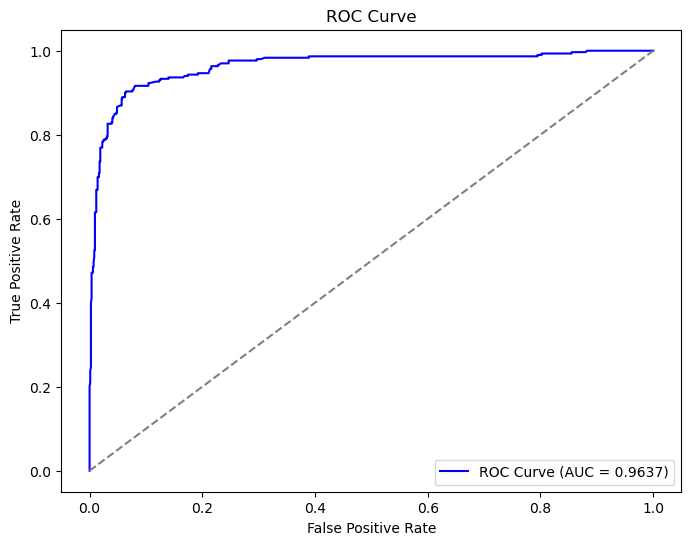

In [16]:

# Step 7: Model Evaluation Metrics on Test Data

# Predict the test set labels
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the metrics
print("Model Evaluation on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate ROC AUC Score
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


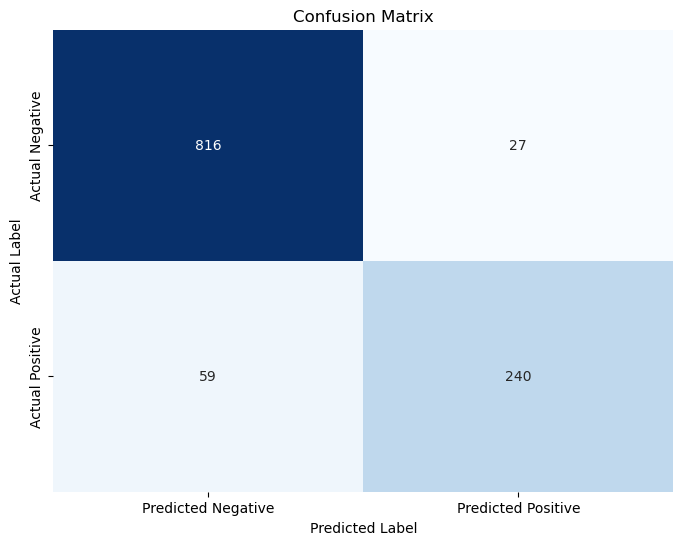

In [18]:

# Step 7 (Alternative Visualization): Confusion Matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


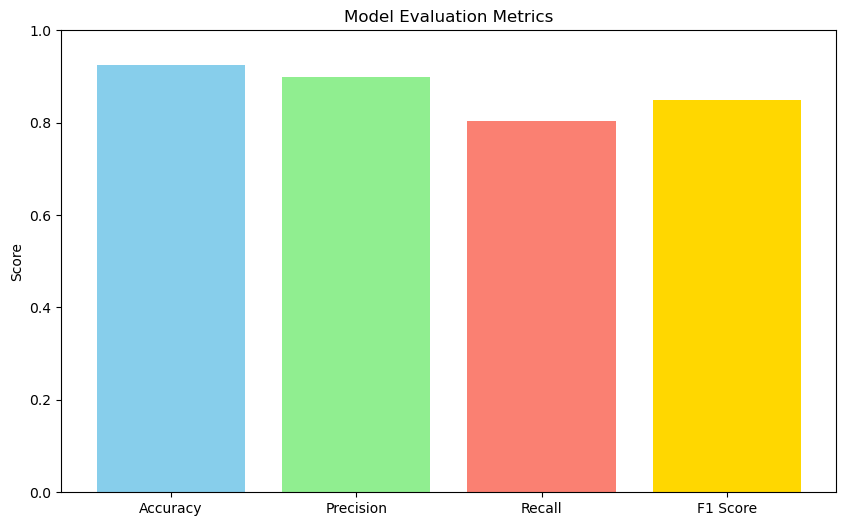

In [20]:

# Step 7 (Alternative Visualization): Bar Plot of Evaluation Metrics

# Define the metric names and their respective values
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
metric_values = [accuracy, precision, recall, f1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, metric_values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better readability
plt.ylabel("Score")
plt.title("Model Evaluation Metrics")
plt.show()


In [26]:
import joblib

# Save the best model to a file
joblib.dump(best_model, 'FP_eng_cond(live).pkl')
print("Model saved as 'FP_eng_cond(live).pkl'")


Model saved as 'FP_eng_cond(live).pkl'


In [28]:
# Load the saved model from the file
loaded_model = joblib.load('FP_eng_cond(live).pkl')
print("Model loaded successfully!")

# Example: Make predictions with the loaded model
new_predictions = loaded_model.predict(X_test)


Model loaded successfully!
